# 1) Dataset

As bases de dados utilizadas são provenientes do **Banco Central do Brasil (BCB)**, mais especificamente do **Sistema Gerenciador de Séries Temporais (SGS)** e da tabela de **Metas da Taxa Selic**.

### Fontes de dados:
- **Sistema Gerenciador de Séries Temporais (SGS/BCB):**  
  [Acessar SGS/BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

- **Metas de taxa para a Selic:**  
  [Acessar Metas da Selic](https://www.bcb.gov.br/estatisticas/detalhamentoGrafico/graficosestatisticas/metaselic)

- **Tabela de estatísticas monetárias e de crédito**  
  (contém as séries administradas pelo SGS em formato `.xlsx`):  
  [Acessar estatísticas monetárias e de crédito](https://www.bcb.gov.br/estatisticas/estatisticasmonetariascredito)


## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [2]:
import time
import math
import requests  # cliente HTTP
import pandas as pd
from datetime import datetime
from pathlib import Path

URL_BASE = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados"

def baixar_sgs(codigo: int, data_inicial: str, data_final: str, tentativas_max: int = 5) -> pd.DataFrame:
    """
    Baixa UMA série do SGS em JSON e devolve DataFrame com colunas: ['dt', f'sgs_{codigo}'].
    data_inicial/data_final no formato 'dd/mm/aaaa'. Backoff simples em caso de erro HTTP.
    """
    parametros = {"formato": "json", "dataInicial": data_inicial, "dataFinal": data_final}
    for tentativa in range(tentativas_max):
        try:
            resp = requests.get(URL_BASE.format(codigo=codigo), params=parametros, timeout=30)
            resp.raise_for_status()
            dados = resp.json()
            df = pd.DataFrame(dados)
            if df.empty:
                return pd.DataFrame(columns=["dt", f"sgs_{codigo}"])
            # Converte data (pode vir dd/mm/aaaa ou mm/aaaa)
            def parsear_data(s):
                for fmt in ("%d/%m/%Y", "%m/%Y"):
                    try:
                        return datetime.strptime(s, fmt)
                    except ValueError:
                        pass
                return pd.NaT
            df["dt"] = df["data"].apply(parsear_data)
            df[f"sgs_{codigo}"] = pd.to_numeric(df["valor"].str.replace(",", "."), errors="coerce")
            saida = df[["dt", f"sgs_{codigo}"]].dropna(subset=["dt"]).copy()
            # normaliza para frequência mensal (MS)
            saida = (
                saida.set_index("dt")
                     .sort_index()
                     .asfreq("MS")  # Month Start
                     .ffill()       # preenche mês faltante com último valor
            )
            saida.reset_index(inplace=True)
            return saida
        except requests.RequestException as e:
            espera = 2 ** tentativa
            time.sleep(espera)
            if tentativa == tentativas_max - 1:
                raise e

def baixar_varias(codigos: list[int], data_inicial: str, data_final: str) -> pd.DataFrame:
    """
    Faz merge (outer) de várias séries por 'dt'. Retorna DataFrame com dt + colunas sgs_XXXX.
    """
    df_todas = None
    for codigo in codigos:
        df_serie = baixar_sgs(codigo, data_inicial, data_final)
        df_todas = df_serie if df_todas is None else df_todas.merge(df_serie, on="dt", how="outer")
    # index mensal e ordenação
    return df_todas.set_index("dt").sort_index().asfreq("MS")

# conjuntos de séries que serão utilizadas na análise
CODIGOS_LIVRES = [20635, 20662, 20634, 20718, 20740, 20717, 20787, 20809, 20786, 21085, 21086, 21112]
CODIGOS_ICC_LIVRES = [25355, 25356, 25354]  # opcional

CODIGOS_DIRECIONADOS = [20686, 20698, 20685, 20757, 20768, 20756, 20826, 20837, 20825, 21132, 21133, 21145]
CODIGOS_ICC_DIRECIONADOS = [25358, 25359, 25357]  # opcional

INCLUIR_ICC = True
CODIGOS_LIVRES_FINAIS = CODIGOS_LIVRES + (CODIGOS_ICC_LIVRES if INCLUIR_ICC else [])
CODIGOS_DIRECIONADOS_FINAIS = CODIGOS_DIRECIONADOS + (CODIGOS_ICC_DIRECIONADOS if INCLUIR_ICC else [])

# datas-alvo
DATA_INICIAL = "01/01/2022"
DATA_FINAL = datetime.today().strftime("%d/%m/%Y")

# baixa e organiza 
df_livres = baixar_varias(CODIGOS_LIVRES_FINAIS, DATA_INICIAL, DATA_FINAL)
df_direcionados = baixar_varias(CODIGOS_DIRECIONADOS_FINAIS, DATA_INICIAL, DATA_FINAL)


conjunto_dados = df_livres.join(df_direcionados, how="outer")

conjunto_dados


,sgs_20635,sgs_20662,sgs_20634,sgs_20718,sgs_20740,sgs_20717,sgs_20787,sgs_20809,sgs_20786,sgs_21085,...,sgs_20756,sgs_20826,sgs_20837,sgs_20825,sgs_21132,sgs_21133,sgs_21145,sgs_25358,sgs_25359,sgs_25357
dt,,,,,,,,,,,,,,,,,,,,,
2022-01-01,178243,200482,378725,21.30,45.51,34.84,10.81,34.58,24.10,3.26,...,9.65,2.57,3.66,3.40,1.27,0.99,1.42,8.57,7.92,8.15
2022-02-01,181252,187146,368398,21.43,47.28,35.95,10.65,36.04,24.91,3.26,...,9.03,2.98,3.88,3.66,1.41,1.08,1.59,8.60,7.95,8.18
2022-03-01,242336,230064,472399,21.39,48.70,36.73,10.14,36.86,25.15,3.41,...,10.05,2.73,3.91,3.62,1.38,1.06,1.55,8.68,7.99,8.23
2022-04-01,200814,223322,424136,22.31,49.06,37.35,10.19,37.17,25.36,3.52,...,11.15,3.24,4.02,3.83,1.34,1.10,1.48,8.76,8.07,8.32
2022-05-01,218693,239059,457752,21.84,49.56,37.46,10.10,37.16,25.35,3.65,...,10.79,1.80,3.93,3.40,1.30,1.08,1.42,8.83,8.19,8.41
2022-06-01,221138,227180,448319,22.56,50.65,38.41,10.45,37.89,25.93,3.62,...,10.57,2.76,3.93,3.64,1.18,1.01,1.27,8.93,8.30,8.52
2022-07-01,198956,227425,426381,23.33,52.44,39.78,10.83,39.27,26.90,3.80,...,11.97,6.86,3.65,4.43,1.21,1.04,1.30,9.10,8.41,8.65
2022-08-01,217395,243934,461329,22.67,53.10,39.98,10.59,40.62,27.67,3.92,...,10.14,3.01,3.96,3.73,1.17,0.96,1.29,9.14,8.51,8.73
2022-09-01,224562,236630,461192,22.80,52.77,39.85,10.94,40.49,27.75,3.98,...,10.44,3.82,4.30,4.19,1.16,0.95,1.27,9.17,8.59,8.79


## Transposição da base: As séries serão linhas e as colunas as datas (mês/ano)

In [3]:
# 1) Garantir ordenação por data e formato amigável do rótulo de coluna (datas)
conjunto_dados = conjunto_dados.sort_index()
rotulos_datas = [dt.strftime("%Y-%m") for dt in conjunto_dados.index]

# 2) Transpor: linhas = séries, colunas = datas
tabela_series = conjunto_dados.T.copy()
tabela_series.columns = rotulos_datas

# 3) (Opcional) Renomear o índice (nome das linhas) para algo mais intuitivo
tabela_series.index.name = "Série"

tabela_series

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08
Série,,,,,,,,,,,,,,,,,,,,,
sgs_20635,178243.00,181252.00,242336.00,200814.00,218693.00,221138.00,198956.00,217395.00,224562.00,200206.00,...,253835.00,311236.00,238004.00,237764.00,259516.00,263452.00,271687.00,264856.00,254695.00,242053.00
sgs_20662,200482.00,187146.00,230064.00,223322.00,239059.00,227180.00,227425.00,243934.00,236630.00,244752.00,...,302443.00,316521.00,302714.00,292589.00,301404.00,309881.00,307889.00,308846.00,319833.00,313525.00
sgs_20634,378725.00,368398.00,472399.00,424136.00,457752.00,448319.00,426381.00,461329.00,461192.00,444958.00,...,556278.00,627758.00,540718.00,530353.00,560920.00,573332.00,579575.00,573702.00,574528.00,555579.00
sgs_20718,21.30,21.43,21.39,22.31,21.84,22.56,23.33,22.67,22.80,23.19,...,21.65,21.73,24.13,23.77,23.47,24.21,24.17,24.29,25.01,25.21
sgs_20740,45.51,47.28,48.70,49.06,49.56,50.65,52.44,53.10,52.77,55.54,...,53.16,53.11,54.28,56.64,56.77,58.01,58.70,59.26,57.94,58.44
sgs_20717,34.84,35.95,36.73,37.35,37.46,38.41,39.78,39.98,39.85,41.63,...,40.86,40.74,42.46,43.85,43.86,45.01,45.64,46.03,45.57,46.04
sgs_20787,10.81,10.65,10.14,10.19,10.10,10.45,10.83,10.59,10.94,11.37,...,9.61,8.56,10.61,10.21,9.75,10.65,10.76,10.91,11.60,11.86
sgs_20809,34.58,36.04,36.86,37.17,37.16,37.89,39.27,40.62,40.49,43.30,...,40.54,39.25,39.90,42.35,42.30,43.75,44.71,45.25,43.93,44.50
sgs_20786,24.10,24.91,25.15,25.36,25.35,25.93,26.90,27.67,27.75,29.57,...,28.46,27.16,28.42,29.84,29.68,31.02,31.87,32.26,31.78,32.32


# Mapa de Séries do Bacen (SGS)

As séries foram organizadas em dois grandes grupos: **Recursos Livres (RL)** e **Recursos Direcionados (RD)**.  
Cada grupo contém informações sobre **concessões de crédito**, **taxas de juros médias**, **spreads bancários** e o **Índice de Custo de Crédito (ICC)**, separados por **Pessoa Jurídica (PJ)**, **Pessoa Física (PF)** e **Total (TOT)**.

---

## 📌 Recursos Livres (RL)

Recursos livres são operações de crédito em que as instituições financeiras têm maior liberdade para definir taxas, prazos e condições, sem vinculação legal obrigatória.

### Concessões de Crédito
- **sgs_20635 → concessoes_RL_PJ**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Jurídica**.  
- **sgs_20662 → concessoes_RL_PF**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Física**.  
- **sgs_20634 → concessoes_RL_TOT**  
  Total de concessões de crédito em recursos livres (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20718 → taxa_RL_PJ**  
  Taxa de juros média das operações de crédito com recursos livres para **PJ**.  
- **sgs_20740 → taxa_RL_PF**  
  Taxa de juros média das operações de crédito com recursos livres para **PF**.  
- **sgs_20717 → taxa_RL_TOT**  
  Taxa de juros média consolidada das operações de crédito com recursos livres.  

### Spread Bancário  
(O spread representa a diferença entre a taxa de juros cobrada do tomador e o custo de captação do banco.)  
- **sgs_20787 → spread_RL_PJ**  
  Spread das operações de crédito com recursos livres para **PJ**.  
- **sgs_20809 → spread_RL_PF**  
  Spread das operações de crédito com recursos livres para **PF**.  
- **sgs_20786 → spread_RL_TOT**  
  Spread médio consolidado em recursos livres.

### Inadimplência da Carteira de Crédito  
(A **inadimplência** representa o percentual de operações de crédito com **atraso superior a 90 dias** em relação ao saldo total da carteira.  
É um importante indicador de **risco de crédito**, refletindo a capacidade dos tomadores de honrarem seus compromissos financeiros.)  
- **sgs_21086 → inad90_RL_PJ**  
  Percentual de operações inadimplentes (>90 dias) para **PJ** em recursos livres.  
- **sgs_21112 → inad90_RL_PF**  
  Percentual de operações inadimplentes (>90 dias) para **PF** em recursos livres.  
- **sgs_21085 → inad90_RL_TOT**  
  Percentual total de operações inadimplentes (>90 dias) em recursos livres.  

### Índice de Custo de Crédito (ICC)  
(O ICC mede o **custo médio do crédito no Brasil**, ponderando diferentes modalidades de crédito. Funciona como um indicador sintético do preço do crédito, semelhante a como o IPCA resume preços.)  
- **sgs_25355 → icc_RL_PJ**  
  Índice de custo do crédito em recursos livres para **PJ**.  
- **sgs_25356 → icc_RL_PF**  
  Índice de custo do crédito em recursos livres para **PF**.  
- **sgs_25354 → icc_RL_TOT**  
  Índice consolidado de custo do crédito em recursos livres.  

---

## 📌 Recursos Direcionados (RD)

Recursos direcionados são operações de crédito com **destinação obrigatória definida em lei**, geralmente com condições favorecidas (ex.: crédito rural, habitacional, BNDES).

### Concessões de Crédito
- **sgs_20686 → concessoes_RD_PJ**  
  Valor de novas concessões de crédito direcionado para **PJ**.  
- **sgs_20698 → concessoes_RD_PF**  
  Valor de novas concessões de crédito direcionado para **PF**.  
- **sgs_20685 → concessoes_RD_TOT**  
  Total de concessões de crédito direcionado (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20757 → taxa_RD_PJ**  
  Taxa de juros média das operações de crédito direcionado para **PJ**.  
- **sgs_20768 → taxa_RD_PF**  
  Taxa de juros média das operações de crédito direcionado para **PF**.  
- **sgs_20756 → taxa_RD_TOT**  
  Taxa de juros média consolidada em crédito direcionado.  

### Spread Bancário
- **sgs_20826 → spread_RD_PJ**  
  Spread das operações de crédito direcionado para **PJ**.  
- **sgs_20837 → spread_RD_PF**  
  Spread das operações de crédito direcionado para **PF**.  
- **sgs_20825 → spread_RD_TOT**  
  Spread médio consolidado em crédito direcionado.

### Inadimplência da Carteira de Crédito  
(A **inadimplência** indica o percentual de operações com **atraso superior a 90 dias** no pagamento.  
Reflete o **risco de crédito** e a saúde da carteira de operações direcionadas.)  
- **sgs_21133 → inad90_RD_PJ**  
  Percentual de operações inadimplentes (>90 dias) para **PJ** em recursos direcionados.  
- **sgs_21145 → inad90_RD_PF**  
  Percentual de operações inadimplentes (>90 dias) para **PF** em recursos direcionados.  
- **sgs_21132 → inad90_RD_TOT**  
  Percentual total de operações inadimplentes (>90 dias) em recursos direcionados.  

### Índice de Custo de Crédito (ICC)
- **sgs_25358 → icc_RD_PJ**  
  Índice de custo do crédito direcionado para **PJ**.  
- **sgs_25359 → icc_RD_PF**  
  Índice de custo do crédito direcionado para **PF**.  
- **sgs_25357 → icc_RD_TOT**  
  Índice consolidado de custo do crédito em recursos direcionados.  

---
### Com esse mapa de séries nós iremos alterar as linha, deixando-as identificáveis

In [4]:
mapa_series = {
    # --------- RECURSOS LIVRES (RL) ---------
    "sgs_20635": "concessoes_RL_PJ_20635",
    "sgs_20662": "concessoes_RL_PF_20662",
    "sgs_20634": "concessoes_RL_TOT_20634",

    "sgs_20718": "taxa_RL_PJ_20718",
    "sgs_20740": "taxa_RL_PF_20740",
    "sgs_20717": "taxa_RL_TOT_20717",

    "sgs_20787": "spread_RL_PJ_20787",
    "sgs_20809": "spread_RL_PF_20809",
    "sgs_20786": "spread_RL_TOT_20786",

    "sgs_21086": "inad90_RL_PJ_21086",
    "sgs_21112": "inad90_RL_PF_21112",
    "sgs_21085": "inad90_RL_TOT_21085",

    "sgs_25355": "icc_RL_PJ_25355",
    "sgs_25356": "icc_RL_PF_25356",
    "sgs_25354": "icc_RL_TOT_25354",

    # --------- RECURSOS DIRECIONADOS (RD) ---------
    "sgs_20686": "concessoes_RD_PJ_20686",
    "sgs_20698": "concessoes_RD_PF_20698",
    "sgs_20685": "concessoes_RD_TOT_20685",

    "sgs_20757": "taxa_RD_PJ_20757",
    "sgs_20768": "taxa_RD_PF_20768",
    "sgs_20756": "taxa_RD_TOT_20756",

    "sgs_20826": "spread_RD_PJ_20826",
    "sgs_20837": "spread_RD_PF_20837",
    "sgs_20825": "spread_RD_TOT_20825",

    "sgs_21133": "inad90_RD_PJ_21133",
    "sgs_21145": "inad90_RD_PF_21145",
    "sgs_21132": "inad90_RD_TOT_21132",

    "sgs_25358": "icc_RD_PJ_25358",
    "sgs_25359": "icc_RD_PF_25359",
    "sgs_25357": "icc_RD_TOT_25357",
}

# renomeia o índice (linhas) usando o dicionário
tabela_series = tabela_series.rename(index=mapa_series)

tabela_series

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08
Série,,,,,,,,,,,,,,,,,,,,,
concessoes_RL_PJ_20635,178243.00,181252.00,242336.00,200814.00,218693.00,221138.00,198956.00,217395.00,224562.00,200206.00,...,253835.00,311236.00,238004.00,237764.00,259516.00,263452.00,271687.00,264856.00,254695.00,242053.00
concessoes_RL_PF_20662,200482.00,187146.00,230064.00,223322.00,239059.00,227180.00,227425.00,243934.00,236630.00,244752.00,...,302443.00,316521.00,302714.00,292589.00,301404.00,309881.00,307889.00,308846.00,319833.00,313525.00
concessoes_RL_TOT_20634,378725.00,368398.00,472399.00,424136.00,457752.00,448319.00,426381.00,461329.00,461192.00,444958.00,...,556278.00,627758.00,540718.00,530353.00,560920.00,573332.00,579575.00,573702.00,574528.00,555579.00
taxa_RL_PJ_20718,21.30,21.43,21.39,22.31,21.84,22.56,23.33,22.67,22.80,23.19,...,21.65,21.73,24.13,23.77,23.47,24.21,24.17,24.29,25.01,25.21
taxa_RL_PF_20740,45.51,47.28,48.70,49.06,49.56,50.65,52.44,53.10,52.77,55.54,...,53.16,53.11,54.28,56.64,56.77,58.01,58.70,59.26,57.94,58.44
taxa_RL_TOT_20717,34.84,35.95,36.73,37.35,37.46,38.41,39.78,39.98,39.85,41.63,...,40.86,40.74,42.46,43.85,43.86,45.01,45.64,46.03,45.57,46.04
spread_RL_PJ_20787,10.81,10.65,10.14,10.19,10.10,10.45,10.83,10.59,10.94,11.37,...,9.61,8.56,10.61,10.21,9.75,10.65,10.76,10.91,11.60,11.86
spread_RL_PF_20809,34.58,36.04,36.86,37.17,37.16,37.89,39.27,40.62,40.49,43.30,...,40.54,39.25,39.90,42.35,42.30,43.75,44.71,45.25,43.93,44.50
spread_RL_TOT_20786,24.10,24.91,25.15,25.36,25.35,25.93,26.90,27.67,27.75,29.57,...,28.46,27.16,28.42,29.84,29.68,31.02,31.87,32.26,31.78,32.32


# Taxa Selic

## 1. O que é a Taxa Selic?
A **Taxa Selic** é a **taxa básica de juros da economia brasileira**.  
- Ela representa o **custo do dinheiro** nas operações de curtíssimo prazo entre instituições financeiras que utilizam títulos públicos federais como garantia.  
- Serve como **referência para todas as demais taxas de juros do país**, como empréstimos, financiamentos e aplicações financeiras.  
- É definida pelo **Comitê de Política Monetária (Copom)** em reuniões periódicas (a cada 45 dias).  
---

## 2. Por que a Selic é importante para o Estudo?
A Selic é fundamental neste estudo porque representa o instrumento central da política monetária brasileira.  
- **Custo do crédito:** Quando o BCB eleva a Selic, o custo de captação dos bancos aumenta, levando a maiores taxas de juros e spreads bancários.
- **Concessões de crédito:** Juros mais altos reduzem a demanda por crédito, refletindo em menor volume de concessões.
- **Risco e inadimplência:** A elevação da Selic encarece o crédito, podendo impactar a capacidade de pagamento dos tomadores e aumentar o risco de inadimplência.

⚖️ Em resumo:  
- A **Selic é a âncora da política monetária brasileira**.  
- Esse mecanismo é central para garantir **estabilidade econômica, previsibilidade e confiança** nos mercados.

---
### No bloco abaixo nós estamos importando a série 4189: Taxa de Juros - Selic acumulada no mês anualizada

In [10]:
# Selic (SGS 4189) no mesmo padrão das demais séries
df_selic = baixar_varias([4189], DATA_INICIAL, DATA_FINAL)  # índice mensal "MS", com ffill
df_selic = df_selic.rename(columns={"sgs_4189": "selic_4189"})  # nome amigável (opcional)
df_selic

,selic_4189
dt,
2022-01-01,9.15
2022-02-01,10.49
2022-03-01,11.15
2022-04-01,11.65
2022-05-01,12.51
2022-06-01,12.89
2022-07-01,13.15
2022-08-01,13.58
2022-09-01,13.65


## Transpondo a base para concatenar com a "tabela_series"

## Junção das bases

In [12]:
# Alinha df_selic ao índice do conjunto_dados (mesmos meses/colunas)
df_selic_alinhada = df_selic.reindex(conjunto_dados.index)

# Transpõe e aplica os mesmos rótulos de coluna (YYYY-MM)
tabela_selic = df_selic_alinhada.T.copy()
tabela_selic.columns = rotulos_datas
tabela_selic.index.name = "Série"

# Versão "com Selic" (sem tocar no tabela_series original)
base = pd.concat([tabela_series, tabela_selic], axis=0)

base

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08
Série,,,,,,,,,,,,,,,,,,,,,
concessoes_RL_PJ_20635,178243.00,181252.00,242336.00,200814.00,218693.00,221138.00,198956.00,217395.00,224562.00,200206.00,...,253835.00,311236.00,238004.00,237764.00,259516.00,263452.00,271687.00,264856.00,254695.00,242053.00
concessoes_RL_PF_20662,200482.00,187146.00,230064.00,223322.00,239059.00,227180.00,227425.00,243934.00,236630.00,244752.00,...,302443.00,316521.00,302714.00,292589.00,301404.00,309881.00,307889.00,308846.00,319833.00,313525.00
concessoes_RL_TOT_20634,378725.00,368398.00,472399.00,424136.00,457752.00,448319.00,426381.00,461329.00,461192.00,444958.00,...,556278.00,627758.00,540718.00,530353.00,560920.00,573332.00,579575.00,573702.00,574528.00,555579.00
taxa_RL_PJ_20718,21.30,21.43,21.39,22.31,21.84,22.56,23.33,22.67,22.80,23.19,...,21.65,21.73,24.13,23.77,23.47,24.21,24.17,24.29,25.01,25.21
taxa_RL_PF_20740,45.51,47.28,48.70,49.06,49.56,50.65,52.44,53.10,52.77,55.54,...,53.16,53.11,54.28,56.64,56.77,58.01,58.70,59.26,57.94,58.44
taxa_RL_TOT_20717,34.84,35.95,36.73,37.35,37.46,38.41,39.78,39.98,39.85,41.63,...,40.86,40.74,42.46,43.85,43.86,45.01,45.64,46.03,45.57,46.04
spread_RL_PJ_20787,10.81,10.65,10.14,10.19,10.10,10.45,10.83,10.59,10.94,11.37,...,9.61,8.56,10.61,10.21,9.75,10.65,10.76,10.91,11.60,11.86
spread_RL_PF_20809,34.58,36.04,36.86,37.17,37.16,37.89,39.27,40.62,40.49,43.30,...,40.54,39.25,39.90,42.35,42.30,43.75,44.71,45.25,43.93,44.50
spread_RL_TOT_20786,24.10,24.91,25.15,25.36,25.35,25.93,26.90,27.67,27.75,29.57,...,28.46,27.16,28.42,29.84,29.68,31.02,31.87,32.26,31.78,32.32


# 2) EDA (Exploratory Data Analysis)

## 1. Definição
**EDA – Análise Exploratória de Dados** é a etapa inicial de um projeto de ciência de dados.  
Ela serve para **entender, limpar e organizar os dados** antes de aplicar modelos estatísticos ou de machine learning.  

👉 Em termos simples: é como "investigar" seus dados para descobrir padrões, erros, outliers (valores muito fora do normal) e relações entre variáveis.

## 2. Objetivos deste EDA
- Visualizar **as séries históricas** (em gráficos, para validar se há sazonalidade).  
- Detectar **valores nulos ou faltantes** (quando uma célula está vazia).  
- Avaliar a **qualidade da informação** (dados duplicados, inconsistentes).  
- Entender a **correlação entre variáveis** (como elas se relacionam).




In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# escolhe o painel
painel = base.copy()


# garante ordem cronologica das colunas e que estao em string "YYYY-MM"
painel.columns = painel.columns.astype(str)
painel = painel.loc[:, sorted(painel.columns)]

# 📉 Visualização das Séries Históricas no EDA

## 1. Objetivo da Visualização
Uma das etapas mais importantes da **Análise Exploratória de Dados (EDA)** é **visualizar as séries históricas** em forma de gráficos.  
O objetivo é **compreender o comportamento temporal das variáveis** e identificar padrões que podem influenciar o modelo de previsão.

Ao observar a série no tempo, conseguimos detectar:

- **Tendência:** direção geral dos dados (ex.: crescimento ou queda ao longo dos meses).  
- **Sazonalidade:** variações que se repetem em períodos regulares (mensais, trimestrais ou anuais).  
- **Ciclos econômicos:** movimentos de alta e baixa associados à conjuntura econômica.  
- **Rupturas estruturais:** pontos em que a série muda de comportamento (ex.: crises, novas políticas de crédito).  
- **Outliers:** valores anômalos que destoam do padrão histórico.

---

## 2. Exemplo de Gráfico de Série Histórica

Cada variável (por exemplo, **spread**, **taxa de juros**, **inadimplência**, **concessões** ou **ICC**) pode ser plotada no tempo usando um **gráfico de linha (line plot)**.

### Exemplo prático:
- **Eixo X:** períodos (meses ou anos).  
- **Eixo Y:** valores da série.  
- **Linhas coloridas:** representam diferentes categorias (ex.: PF, PJ, Total).

Esse tipo de visualização ajuda a:
- Confirmar a **estabilidade** ou **volatilidade** das variáveis.  
- Detectar **picos sazonais** (ex.: maior concessão de crédito no fim do ano).  
- Avaliar se a série precisa de **transformações adicionais** (como diferenciação, normalização ou logaritmo) antes de modelar.

---

## ✅ Conclusão
Visualizar as séries históricas é um passo essencial no **EDA** porque permite **entender a história dos dados antes de modelar**.  
Sem essa etapa, corre-se o risco de ignorar:
- Padrões sazonais importantes,  
- Tendências estruturais, ou  
- Ruídos que distorcem as previsões.

📊 Em resumo: **“O gráfico é o primeiro diagnóstico da série temporal.”**


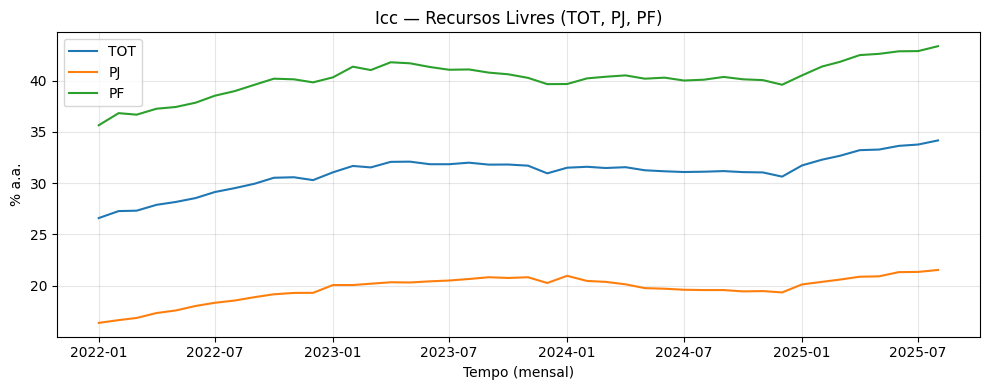

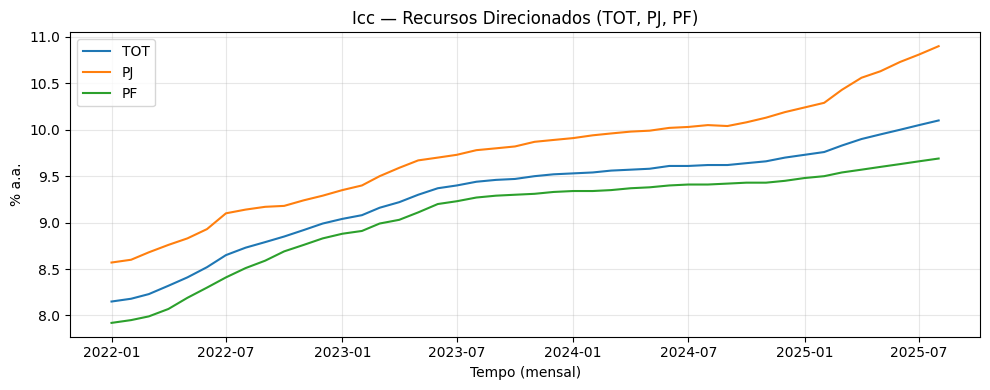

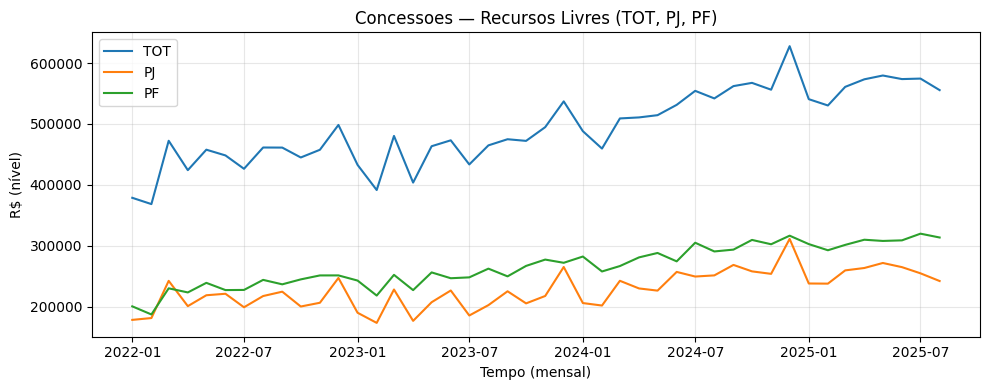

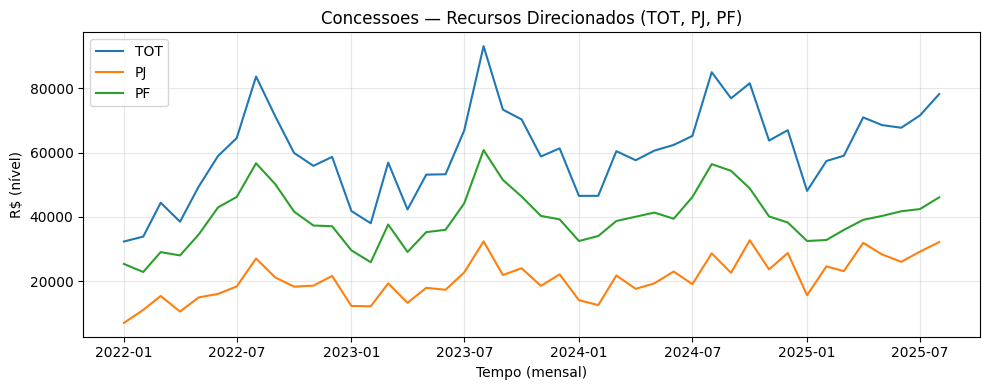

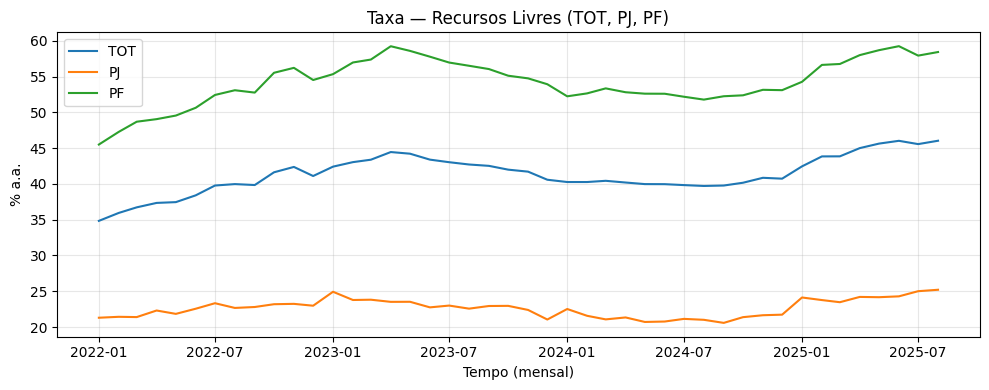

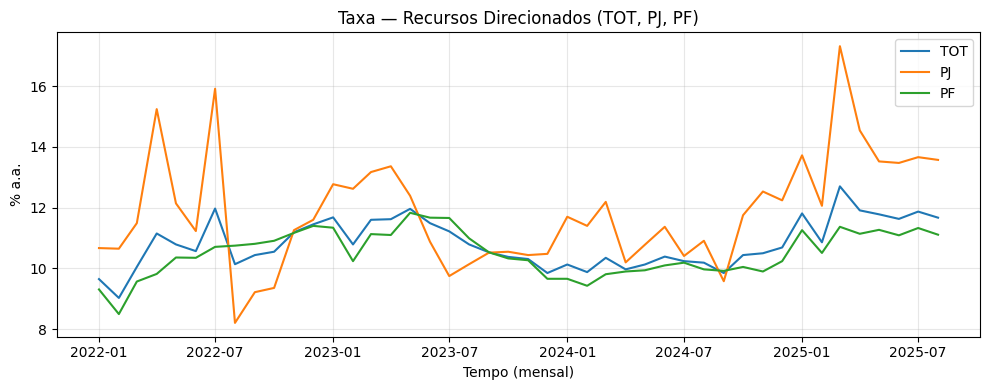

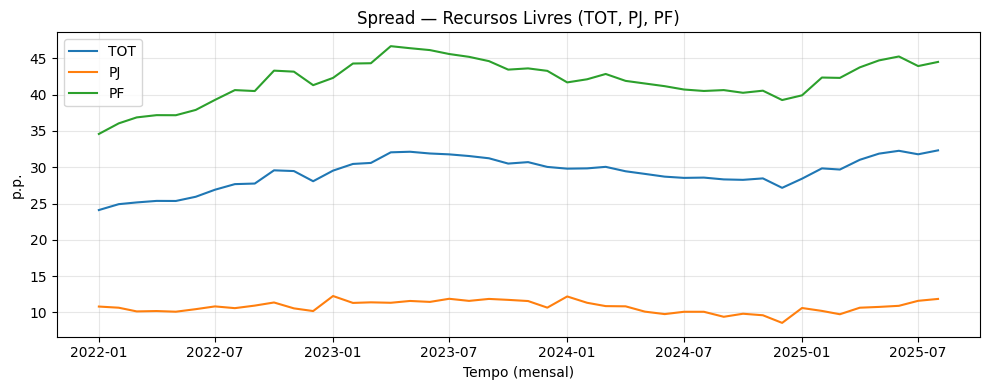

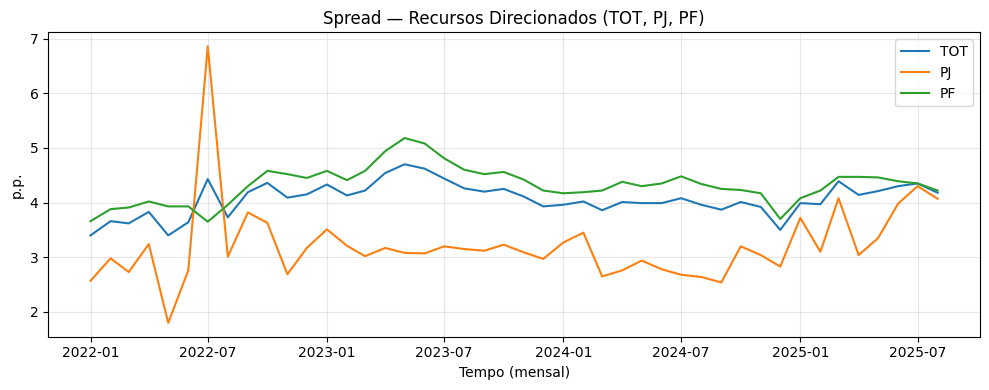

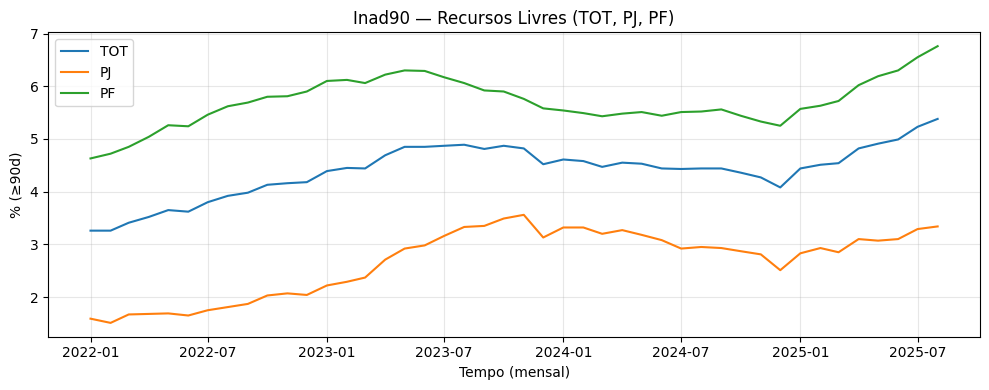

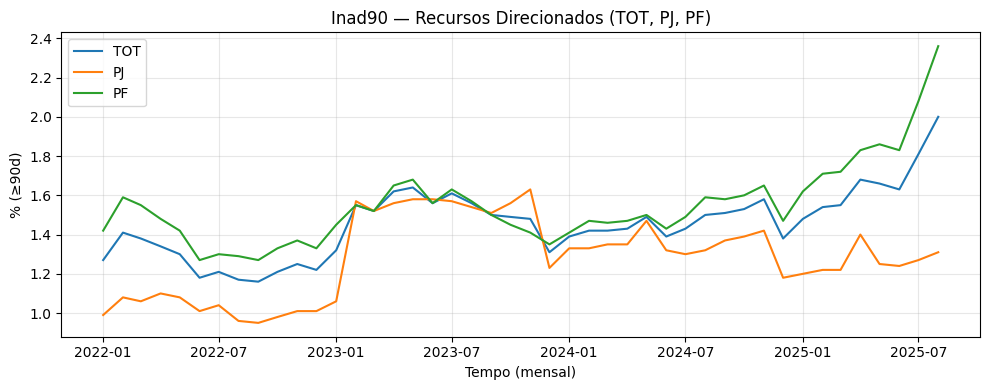

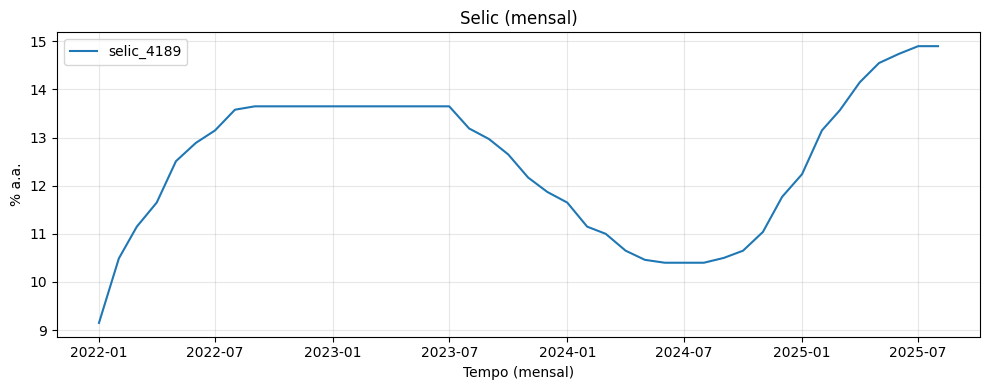

In [17]:
PERIODO_INI = "2022-01"
PERIODO_FIM = "2025-08"
cols = [c for c in painel.columns if PERIODO_INI <= c <= PERIODO_FIM]
if cols:
    painel = painel.loc[:, cols]

eixo_tempo = pd.to_datetime(pd.Index(painel.columns) + "-01")

# ==========================
# 1) Mapeamento explícito (inclui INAD e SELIC)
# ==========================
SERIES = {
    ("icc", "RL"): {
        "TOT": "icc_RL_TOT_25354",
        "PJ" : "icc_RL_PJ_25355",
        "PF" : "icc_RL_PF_25356",
    },
    ("icc", "RD"): {
        "TOT": "icc_RD_TOT_25357",
        "PJ" : "icc_RD_PJ_25358",
        "PF" : "icc_RD_PF_25359",
    },
    ("concessoes", "RL"): {
        "TOT": "concessoes_RL_TOT_20634",
        "PJ" : "concessoes_RL_PJ_20635",
        "PF" : "concessoes_RL_PF_20662",
    },
    ("concessoes", "RD"): {
        "TOT": "concessoes_RD_TOT_20685",
        "PJ" : "concessoes_RD_PJ_20686",
        "PF" : "concessoes_RD_PF_20698",
    },
    ("taxa", "RL"): {
        "TOT": "taxa_RL_TOT_20717",
        "PJ" : "taxa_RL_PJ_20718",
        "PF" : "taxa_RL_PF_20740",
    },
    ("taxa", "RD"): {
        "TOT": "taxa_RD_TOT_20756",
        "PJ" : "taxa_RD_PJ_20757",
        "PF" : "taxa_RD_PF_20768",
    },
    ("spread", "RL"): {
        "TOT": "spread_RL_TOT_20786",
        "PJ" : "spread_RL_PJ_20787",
        "PF" : "spread_RL_PF_20809",
    },
    ("spread", "RD"): {
        "TOT": "spread_RD_TOT_20825",
        "PJ" : "spread_RD_PJ_20826",
        "PF" : "spread_RD_PF_20837",
    },
    # ---- INADIMPLÊNCIA (90+ dias)
    ("inad90", "RL"): {
        "TOT": "inad90_RL_TOT_21085",
        "PJ" : "inad90_RL_PJ_21086",
        "PF" : "inad90_RL_PF_21112",
    },
    ("inad90", "RD"): {
        "TOT": "inad90_RD_TOT_21132",
        "PJ" : "inad90_RD_PJ_21133",
        "PF" : "inad90_RD_PF_21145",
    },
}

UNIDADES = {
    "icc": "% a.a.",
    "concessoes": "R$ (nível)",
    "taxa": "% a.a.",
    "spread": "p.p.",
    "inad90": "% (≥90d)",
    "selic": "% a.a.",
}

TITULO = {
    "RL": "Recursos Livres",
    "RD": "Recursos Direcionados",
}

# ==========================
# 2) Funções de plot
# ==========================
def plotar_indicador(indicador: str, grupo: str):
    nomes = SERIES.get((indicador, grupo), {})
    if not nomes:
        print(f"[aviso] mapeamento ausente para {indicador.upper()} - {grupo}")
        return

    plt.figure(figsize=(10,4))
    for seg in ["TOT", "PJ", "PF"]:
        nome = nomes.get(seg)
        if nome is None or nome not in painel.index:
            continue
        y = pd.to_numeric(painel.loc[nome], errors="coerce").values
        plt.plot(eixo_tempo, y, label=seg)

    plt.title(f"{indicador.capitalize()} — {TITULO[grupo]} (TOT, PJ, PF)")
    plt.ylabel(UNIDADES.get(indicador, ""))
    plt.xlabel("Tempo (mensal)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plotar_selic():
    """Plota a(s) série(s) de Selic disponível(is). Prioriza nomes comuns."""
    candidatos = [n for n in ["selic_aa", "selic_4189"] if n in painel.index]
    if not candidatos:
        print("[aviso] nenhuma série de Selic encontrada (procure por 'selic_aa' ou 'selic_4189').")
        return
    plt.figure(figsize=(10,4))
    for nome in candidatos:
        y = pd.to_numeric(painel.loc[nome], errors="coerce").values
        plt.plot(eixo_tempo, y, label=nome)
    plt.title("Selic (mensal)")
    plt.ylabel(UNIDADES["selic"])
    plt.xlabel("Tempo (mensal)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==========================
# 3) Rodar: 1 gráfico por indicador (RL e RD) + Selic
# ==========================
for indicador in ["icc", "concessoes", "taxa", "spread", "inad90"]:
    for grupo in ["RL", "RD"]:
        plotar_indicador(indicador, grupo)

plotar_selic()

# 📈 Correlação com as Séries-Alvo (Spreads)

### O que é correlação?
- É uma **medida estatística** que mostra **o quanto duas variáveis se relacionam**.  
- Vai de **-1 a +1**:  
  - **+1** = correlação perfeita positiva (sobem juntas).  
  - **-1** = correlação perfeita negativa (quando uma sobe, a outra cai).  
  - **0** = sem relação linear.

### No projeto de spreads
- As **séries-alvo** são os diferentes tipos de **spread bancário** (ex.: `spread_RL_PJ`, `spread_RD_TOT`).  
- A ideia é verificar quais variáveis (juros, concessões, ICC) têm maior relação com cada spread.  

### Exemplo de gráfico de correlação (heatmap)
- Cada célula mostra o **coeficiente de correlação**.  
- Cores quentes (vermelho) = correlação forte positiva.  
- Cores frias (azul) = correlação negativa.  

Esse gráfico ajuda a **visualizar de forma rápida quais variáveis explicam melhor os spreads**.

In [19]:
# listas das series-alvo 
spreads_alvo = [
    "spread_RD_TOT_20825",
    "spread_RD_PJ_20826",
    "spread_RD_PF_20837",
    "spread_RL_TOT_20786",
    "spread_RL_PJ_20787",
    "spread_RL_PF_20809",  
]

# filtra apenas as que existem no painel
spreads_presentes = [s for s in spreads_alvo if s in painel.index]
if len(spreads_presentes) == 0:
    raise ValueError("Nenhuma das series de spread informadas foi encontrada no painel.")

def correlacoes_com_alvo(painel: pd.DataFrame, alvo: str, top_n: int = 15) -> pd.DataFrame:
    """
    Calcula correlacao de Pearson entre a serie 'alvo' (linha do painel)
    e todas as demais series, usando apenas os meses onde o 'alvo' tem dado.
    Retorna dataframe ordenado por |correlacao|.
    """
    # alvo como numerico
    s_alvo = pd.to_numeric(painel.loc[alvo], errors="coerce")
    # meses validos do alvo
    cols_validas = s_alvo.index[s_alvo.notna()]
    if len(cols_validas) < 3:
        return pd.DataFrame(columns=["corr", "abs"])

    # outras series como numerico, alinhadas nas mesmas colunas validas
    outros = painel.drop(index=[alvo], errors="ignore")
    outros = outros.loc[:, cols_validas].apply(pd.to_numeric, errors="coerce")

    # remove colunas com NaN no alvo (ja filtrado) e calcula correlacao
    corr = outros.T.corrwith(s_alvo.loc[cols_validas])
    corr = corr.dropna()
    res = pd.DataFrame({"corr": corr, "abs": corr.abs()}).sort_values("abs", ascending=False)
    return res.head(top_n)

# calcula e mostra as tabelas de correlacao para cada spread-alvo
tabelas_corr = {}
for alvo in spreads_presentes:
    print(f"\n=== Correlações com alvo: {alvo} ===")
    tab = correlacoes_com_alvo(painel, alvo, top_n=15)
    tabelas_corr[alvo] = tab
    display(tab)


=== Correlações com alvo: spread_RD_TOT_20825 ===


,corr,abs
Série,,
spread_RL_PF_20809,0.815274,0.815274
spread_RD_PF_20837,0.812541,0.812541
inad90_RL_PF_21112,0.794183,0.794183
taxa_RL_PF_20740,0.793250,0.793250
spread_RL_TOT_20786,0.778193,0.778193
taxa_RL_TOT_20717,0.739689,0.739689
taxa_RD_PF_20768,0.719308,0.719308
icc_RL_PF_25356,0.711580,0.711580
inad90_RL_TOT_21085,0.671135,0.671135



=== Correlações com alvo: spread_RD_PJ_20826 ===


,corr,abs
Série,,
spread_RD_TOT_20825,0.504042,0.504042
taxa_RD_PJ_20757,0.498762,0.498762
taxa_RL_PJ_20718,0.495252,0.495252
taxa_RD_TOT_20756,0.494203,0.494203
selic_4189,0.418987,0.418987
taxa_RD_PF_20768,0.313475,0.313475
taxa_RL_TOT_20717,0.312676,0.312676
inad90_RL_PF_21112,0.294386,0.294386
taxa_RL_PF_20740,0.272681,0.272681



=== Correlações com alvo: spread_RD_PF_20837 ===


,corr,abs
Série,,
spread_RL_PF_20809,0.837442,0.837442
spread_RD_TOT_20825,0.812541,0.812541
spread_RL_TOT_20786,0.775779,0.775779
taxa_RL_PF_20740,0.732660,0.732660
inad90_RL_PF_21112,0.722584,0.722584
inad90_RL_TOT_21085,0.659718,0.659718
icc_RL_PF_25356,0.654384,0.654384
taxa_RL_TOT_20717,0.643221,0.643221
taxa_RD_PF_20768,0.627082,0.627082



=== Correlações com alvo: spread_RL_TOT_20786 ===


,corr,abs
Série,,
spread_RL_PF_20809,0.977440,0.977440
inad90_RL_TOT_21085,0.946354,0.946354
icc_RL_PJ_25355,0.931667,0.931667
icc_RL_PF_25356,0.924982,0.924982
taxa_RL_PF_20740,0.922282,0.922282
icc_RL_TOT_25354,0.919265,0.919265
taxa_RL_TOT_20717,0.905622,0.905622
inad90_RL_PF_21112,0.896561,0.896561
spread_RD_TOT_20825,0.778193,0.778193



=== Correlações com alvo: spread_RL_PJ_20787 ===


,corr,abs
Série,,
concessoes_RL_PJ_20635,-0.606079,0.606079
inad90_RL_PF_21112,0.560222,0.560222
spread_RL_TOT_20786,0.547991,0.547991
spread_RD_TOT_20825,0.547409,0.547409
spread_RL_PF_20809,0.543093,0.543093
taxa_RL_PJ_20718,0.529594,0.529594
spread_RD_PF_20837,0.473515,0.473515
selic_4189,0.461536,0.461536
concessoes_RL_TOT_20634,-0.448247,0.448247



=== Correlações com alvo: spread_RL_PF_20809 ===


,corr,abs
Série,,
spread_RL_TOT_20786,0.977440,0.977440
taxa_RL_PF_20740,0.932992,0.932992
inad90_RL_PF_21112,0.893695,0.893695
taxa_RL_TOT_20717,0.876983,0.876983
icc_RL_PF_25356,0.874746,0.874746
inad90_RL_TOT_21085,0.874740,0.874740
icc_RL_PJ_25355,0.864532,0.864532
icc_RL_TOT_25354,0.843589,0.843589
spread_RD_PF_20837,0.837442,0.837442


## Área de teste

In [11]:
for alvo, tab in tabelas_corr.items():
    tab.to_csv(f"correlacoes_{alvo}.csv", encoding="utf-8-sig")
